<a href="https://colab.research.google.com/github/Ajjme/Climate_Response_Modeling/blob/main/Earth_Heat_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import ode4u as m
#import multivarious as m

# One layer heat energy model for the earth

In [2]:
# this is the ODE4u function
def ode4u(odefun, time, x0, u=None, c=None):
    """
    Solve a system of nonhomogeneous ODEs using the 4th-order Runge-Kutta method.
    (it depends on not just time and state but also external inputs (u) and constanstant (c))

    Parameters:
        odefun : function (t, x, u, c) -> (dxdt, y)
                 returns state derivative and output as arrays
        time   : time values at which the solution is computed.
                 p-dimensional array
        x0     : n-dimensional array, state at time[0].
        u      : (m x p) dimensional array
                 optional input sampled at each time step.
        c      : optional constants passed to odefun.

    Returns:
        time   : ndarray, shape (1, p)
        x_sol  : ndarray, shape (n, p)
        x_drv  : ndarray, shape (n, p)
        y_sol  : ndarray, shape (m, p)
    """

    time   = np.asarray(time)
    x0     = np.asarray(x0).flatten()
    points = len(time) # the total number of time steps

    # create defaults if not provided
    if c is None:
        c = 0
    if u is None:
        u = np.zeros((1, points))
    else:
        u = np.asarray(u)

    # verify inputs recieved are in 2D array shape
    if u.ndim == 1:
        u = u[np.newaxis, :]

    if u.shape[1] < points:
        pad_width = points - u.shape[1]
        u = np.pad(u, ((0, 0), (0, pad_width)), mode='constant')

    # state derivitives and outputs at time[0]
    dxdt0, y0 = odefun(time[0], x0, u[:, 0], c)

    n = x0.size                 # number of states
    m = np.asarray(y0).size     # nuber of outputs

    # allocate memory
    x_sol = np.ones([n, points])*np.nan
    x_drv = np.ones([n, points])*np.nan
    y_sol = np.ones([m, points])*np.nan

    x_sol[:, 0] = x0    # states
    x_drv[:, 0] = dxdt0 # state derivitives
    y_sol[:, 0] = y0    # outputs

    for p in range(points - 1):  # time stepping loop and main integration
        t = time[p]
        dt = time[p + 1] - t
        dt2 = dt / 2.0

        u_mid = (u[:, p] + u[:, p + 1]) / 2.0

        # intermediate dervitives
        dxdt1, _ = odefun(t + dt2, x0 + dxdt0 * dt2, u_mid, c)
        dxdt2, _ = odefun(t + dt2, x0 + dxdt1 * dt2, u_mid, c)
        dxdt3, _ = odefun(t + dt,  x0 + dxdt2 * dt, u[:, p + 1], c)

        # state update using the intermediate derivities
        x0 = x0 + ( dxdt0 + 2 * (dxdt1 + dxdt2) + dxdt3 ) * dt / 6.0

        # state derivitives and outputs at start of time (p+1)
        dxdt0, y0 = odefun(time[p + 1], x0, u[:, p + 1], c)

        # save states (solution), state derivitives, and outputs
        x_sol[:, p+1] = x0    # state
        x_drv[:, p+1] = dxdt1 # state derivitives
        y_sol[:, p+1] = y0    # output

        # safety - incase NaN or Inf
#       if not np.all(np.abs(x0) > 1e12):
        if not np.all(np.isfinite(x0)):
            break

    return time, x_sol, x_drv, y_sol

In [3]:
#!/usr/bin/env python3

# Sources
# https://en.wikipedia.org/wiki/Idealized_greenhouse_model
# https://en.wikipedia.org/wiki/Heat_transfer_coefficient
# https://www.engineersedge.com/thermodynamics/overall_heat_transfer-table.htm
# https://enghandbook.com/thermodynamics/heat-transfer/

''' ... in console
import importlib , earth_heat_1
importlib.reload(earth_heat_1)
'''

# constants
# ---------
class c:
    pi  = np.pi
    c   =  299.792458e6       # speed of light  m/s
    h   =    6.62607015e-34   # Planck's constant  J/Hz
    k   =    1.380649e-23     # Boltzmann's constant J/deg K
    sbc =    5.670367e-8;     # Stefan-Boltzmann constant  ... W/sq.m/deg K^4
    Rs  =    6.9570e08        # radius of sun, m
    D   =    1.4960e11        # sun - to - earth distance, m
    Re  =    6.3567523e6      # radius of earth, m
    Ts  = 5777.               # sun temperature, K
    aa  =    0.30             # earth albedo 0.3 to 0.4 of solar reflected
    ee  =    0.78       # ??  # emissivity without GHG: 0.78  with GHG: 0.80
    sec_per_yr = 365*24*3600  # seconds per year
    years = 1000              # years in the simulation
    ocn_depth = 1500    # ??  # depth of ocean m
    ocn_density = 1023.6      # density of seawater kg/cu.m
    ocn_shc = 4005            # specific heat capacity ocean water J/(kg K)

# computed constants
# ------------------
    # solar constant W/sq.m  ...
    solar_const = sbc*Ts**4 * 4*pi*Rs**2 / (4*pi*D**2)
    # ocean heat capacity per sq.m J/(sq.m K) ...
    ocn_ahc = ocn_shc * ocn_density * ocn_depth

# define the dynamical system in terms of a set of o.d.e's
# --------------------------------------------------------
def sys(t, x, u, c):
    """
    compute the state derivive dxdt at any point in time, any state, any input
    x =  Q_ocn   state  ... heat in ocean J/sq.m
    """
    Q_ocn = x # extract individual states from the vector of states , J/sq.m

    T_ocn = Q_ocn / c.ocn_ahc      #   ocean    deg K

    dQ_ocn_dt = u[0]  - c.sbc*T_ocn**4

#   print("T_atm=",T_atm,"Q_atm=",Q_atm, "dQ_atm_dt=", dQ_atm_dt, "T_ocn=",T_ocn, "Q_ocn=", Q_ocn, "dQ_ocn_dt=", dQ_ocn_dt)

    dxdt = np.array( dQ_ocn_dt ) # rate of change of heat per sq.m

    y = np.array( T_ocn ) # temperature deg C

    return dxdt, y


# run the simulation
# --------------------------------------------------------
def run():
# time
# ----
    time_init = 0.0                              # initial time, s
    time_end  = c.sec_per_yr * c.years           # final time, s
    time_step = c.sec_per_yr/12                  # time step, s
    N = int((time_end - time_init) / time_step)  # number of time steps
    time = time_init + np.linspace( 0, N-1, N )*time_step # time sequence

# initial state values
# --------------------
# K initial temp in the atmosphere and oceans
    x_init = np.array( [ c.ocn_ahc*0 ] )

# external forcing
# --------------------
# short wavelength solar input over the surface W/sq.m
    u = (1-c.aa)*(c.solar_const/4)*np.ones(N)

# solve the ode's for heat and temperature in the atmosphere and ocean
# --------------------------------------------------------------------
    time, x, x_drv, y = ode4u( sys , time , x_init , u , c )

    nY = len(y)

    print("nY=",nY)

# print results at 10 years and at steady state:
# ----------------------------------------------------
    print("The temperatures of the ocean")
    print("year=",time[120]/c.sec_per_yr,"T_ocn=",y[0,120]-273)
    print("year=",time[-1]/c.sec_per_yr,"T_ocn=",y[0,-1]-273)
    print("sbc=",c.sbc, "solar constant=", c.solar_const, "u=",u[0])

# ---------------------------------------------------------- Plots
    fontsize = 9
    plt.rcParams['font.size'] = fontsize
    plt.ion()                 # interactive mode

    f1 = plt.figure(1)

#   fig=plt.figure(figsize=(4.2,4.3),dpi=300);
#   plt.subplot(3,1,1)
    plt.plot(time/c.sec_per_yr, y[0,:]-273, "-", color='MidnightBlue', label="ocean")
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time (years)')
#   plt.xlim([0,200])
#   plt.ylim([0,4])
#   plt.title('Atm/ Ocean temperature anomalies given a sudden 2x CO฀ increase')
    plt.legend(loc='lower right',fontsize=fontsize-1)
    plt.grid(lw=0.25)
    plt.title("(a)",loc="left",fontsize=fontsize)

    plt.show()     # close the plot window to end the script


nY= 1
The temperatures of the ocean
year= 10.0 T_ocn= -260.7419442580196
year= 999.9166666666666 T_ocn= -18.195516070962412
sbc= 5.670367e-08 solar constant= 1365.8451291489353 u= 239.02289760106365


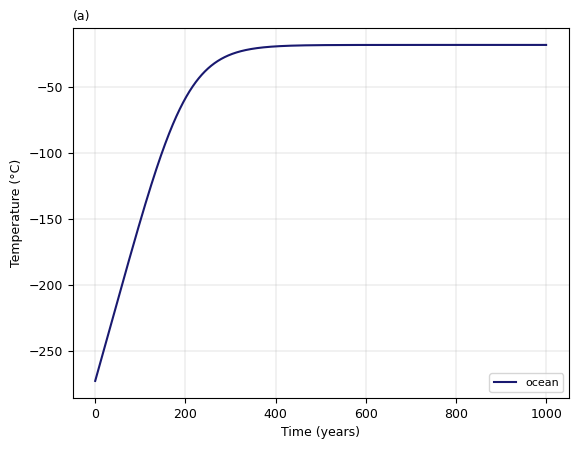

In [4]:
run()